# Import Packages

In [1]:
# importing all the necessary packages
import pandas as pd # Dataframe package
import matplotlib.pyplot as plt # Plotting package
import numpy as np # Numerical computation package
import seaborn as sns # Plotting package
from sklearn.neural_network import MLPRegressor # neural network 
from sklearn.ensemble import RandomForestRegressor # Random Forest estimator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from PIL import Image

np.random.seed(1) # Set the random seed for reproduceability

# Data cleaning

In [ ]:
np.random.seed(1) # Set the random seed for reproduceability

ped = pd.read_csv("köln-schildergasse (west)-20180430-20200131-hour.csv", sep = ";")
holi = pd.read_csv("Feiertage_2018.01.01_2020.01.31.csv", sep = ";")
##########################################print(ped.head(3))
##########################################print(holi.head(3))
#test


#########################################################################
#Machen wir das in eine Neue Box oder nicht? Die Print sachen können wir sonst raus nehmen?
#########################################################################


#Splitting up the Time of measurement into date and time
ped[["date", "time"]] = ped["time of measurement"].str.split(" ", n=1, expand=True)
#Drpo Time of measuremnt, because it is split now and drop location
ped = ped.drop(["time of measurement", "location"], axis=1)
#Drop incidents, if only nan
ped.dropna(how='all', axis=1, inplace=True)

# restructure by date
ped = ped[ ["date", "time"] + [ col for col in ped.columns if col != "date" and col!= "time"] ]
#change name
holi = holi.rename(columns={"name": "holiday"})
#merge on date
ped = pd.merge(ped, holi, how = "left")

#put hollyday as 1 and no holyday as 0
ped["holiday"] = ped["holiday"].fillna(0)
ped["holiday"] = ped["holiday"].where(ped["holiday"] == 0, 1)

# clear time from the minute variation
ped["time"] = ped["time"].str.slice_replace(8, 16)

# Get a better insight into the weather data and missing data
##########################################print(ped["weather condition"].unique())
##########################################print(ped.isnull().sum() / ped.shape[0])

#See where the data are missing
null_data = ped[ped.isnull().any(axis=1)]
##########################################print(null_data)


#########################################################################
#Machen wir das in eine Neue Box oder nicht? Die Print sachen können wir sonst raus nehmen?
#########################################################################


#because the data for temperature and weather condition are both missing, this can be dropped, due to the huge sample size
ped.dropna(inplace=True)

#Import datapackages
from datetime import date, timedelta
from datetime import datetime

#Import Dataframe from the holidays
school_holi = pd.read_csv("OpenData_Ferientermine.csv", sep = ";")
days_df_list = []

#Create dataframe with all dates singular listed 
for i in range(school_holi.shape[0]):
    #Get the start and enddate from the holidays
    start_date = datetime.strptime(school_holi["ErsterTagDate"][i], "%d.%m.%Y").date()
    end_date = datetime.strptime(school_holi["LetzterTagDate"][i], "%d.%m.%Y").date()

    #create dataframes out of the range and append to a list
    delta = end_date - start_date
    days = [start_date + timedelta(days=n) for n in range(delta.days + 1)]
    days_df = pd.DataFrame (days, columns = ['date'])
    days_df_list.append(days_df)

#create single dataframe out of the list and add value 1 for holiday
new_holi = pd.concat(days_df_list).reset_index(drop=True)
new_holi["school holiday"] = 1
new_holi["date"] = new_holi["date"].astype(str)

#merg of the two frames
ped = pd.merge(ped, new_holi, how = "left", on="date")
ped["school holiday"] = ped["school holiday"].fillna(0)

#change float to int
ped["school holiday"] = np.int64(ped["school holiday"].astype(int))

#Get Column with months
ped["months"] = ped["date"].str.slice(5, 7)

#Transform time to hours
ped["hour"] = ped["time"].str.slice(0, 2)


# Save for the API
ped.to_csv("data_clean_without_dummies.csv", sep = ";")


#get dummies for models
ped = pd.get_dummies(ped, columns=["weekday", "weather condition", "months", "hour"])


#########################################################################
#Machen wir das in eine Neue Box oder nicht? Die Print sachen können wir sonst raus nehmen?
#########################################################################

#Creating the PCA and look if we can safe data storage

# For PCA, we want to standardize our data, i.e., de-mean it and divide it by the standard deviation
standardize = lambda x: (x - x.mean()) / x.std()
ped["temperature in ºc"] = standardize(ped["temperature in ºc"])


###################################################################################
#Dieser Teil ist für die PCA (klappt das alles?), Die PC sind alle hinten dran gehängt
###################################################################################
#Safe all features to calculate the cpa
features = ped.columns[3:] # Features

# Column names for our principal components
principal_components = [f"PC{i+1}" for i in range(len(features))]

# Run PCA with 4 principal components on our iris data
pca = PCA(n_components=len(features))
ped[principal_components] = pca.fit_transform(ped[features])


###################################################################################
#57 sind die Columns, ab dem pca los geht und k giebt an, wie viele benötigt werden für die Schwelle
###################################################################################
threshhold = 0.99
k = np.argmax(pca.explained_variance_ratio_.cumsum() >= threshhold)
print(k)
print(ped.columns[57:])
###################################################################################

#save prepeared data
ped.to_csv("data_clean_with_dummies.csv")



# Visualizing our Data

# Neural Network with MLP Regressor

In [2]:
# importing the data and splitting it into a train and test set to work with
# important!! use index_col=0 to read df otherwise pca starts at col 58 ("unnamed" is being dropped)
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same data, for reproduceability
np.random.seed(1) 

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

## Hyperparameter Tuning

### 1. Establish Base Scenario

In [3]:
# initialize a neural network with the default parameters 
nnet_base = MLPRegressor()

In [4]:
# scale the data to work so it is less sensitive to feature scaling 
# normally we wouldn't use scaling if we already applied PCA to our data
# MLP Regressor doesn't work otherwise and has problems with matrix multiplication
# therefore we use scaling of the features and outputs in this prediction model
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest)
Xtest_scaled = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std()
ytest_scaled = (ytest - mu) / sigma
ytrain_scaled = (ytrain - mu) /sigma

In [156]:
# creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# defining a function to fit the scenario and evaluate it
def scenario_fit_evaluate(model, display_name, scenario, traindataX_sc, traindatay_sc, testdataX_sc, testdatay_sc):
    global comparison
    # Fit the network to the scaled train data
    scenario.fit(traindataX_sc, traindatay_sc)

    # Make predictions
    ypred_train_scaled = scenario.predict(traindataX_sc)
    ypred_scaled = scenario.predict(testdataX_sc)

    # Reconstruct outputs and scale back predictions
    ytest = testdatay_sc * sigma + mu
    ytrain = traindatay_sc * sigma + mu
    ypred_train = ypred_train_scaled * sigma + mu
    ypred = ypred_scaled * sigma + mu
    # the network predicts negative values because it is not possible to put an activation function on the output layer
    # MLPRegressor uses the activation function only on the hidden layers
    # Negative Values make no sense in our case, therefore we fix it and tell the network that all negative values
    # should equal to zero
    ypred[ypred < 0] = 0

    # Compute the MAE
    mae_train = mean_absolute_error(ytrain, ypred_train)
    mae_test = mean_absolute_error(ytest, ypred)
    # Comute R^2
    r2_train = r2_score(ytrain, ypred_train)
    r2_test = r2_score(ytest, ypred)

    # adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[model, display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("comparison_mae_r2.csv", sep=";", index=False)
    print(comparison)

In [157]:
scenario_fit_evaluate("MLP Regressor", "Base Scenario", nnet_base, 
    Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  383.353667  488.387109  0.960602  0.937584


In [ ]:
# plot the results to see the results of our base scenario
fig, ax = plt.subplots(figsize=(16, 12))

#create a linspace to match the y-values
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

# plot the true values for 2 pca variables
ax.scatter(xs, ytest, label="true values", alpha=0.6)

# plot the predictions
ypred_scaled = nnet_base.predict(Xtest_scaled)
ypred = ypred_scaled * sigma + mu
ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)
# there are negative values as a prediction of pedestrians because with MLP Regressor it is not possible to 
# put an activation function on the output layer, it only works on the hidden layers
# therefore in further predictions all values of ypred < 0 are going to be 0, so the scenario makes sense

# Add labels and legend
ax.set_ylabel("Pedestrians")
ax.legend()

### 2. Analyze the Influence of the Different Parameters

In [ ]:
# conduncting the parameter analysis on the most used parameters for optimization
# how many hidden layers with how many neurons are we going to use
# 100 is the default value, other values chosen randomly to see the effect of more layers
hidden_layer_sizes = [(100,), (32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)]
# activation function that is going to be used on the hidden layers, relu is the default value
activations = ["relu", "logistic", "tanh", "identity"]
# the solver which optimizes the weights, adam is the default value
solvers = ["sgd", "adam"]
# regularization: avoids overfitting, 0.0001 is the default value
alphas = np.linspace(0.00001, 0.001, 50)
# how high is the initial learing rate, 0.001 is the default value
learing_rate_inits = np.linspace(0.001, 0.01, 50)
# number of epochs, 200 is the default value
# often it doesn't converge then so we start at 1000
max_iters = range(1000, 2000, 20)

In [ ]:
# creating a dataframe to save the results
results = pd.DataFrame(columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter(param, param_values, initialize_model):
    global results
    for param_value in param_values:
        nnet_param = initialize_model(param_value)
        # Fit the network to the train data
        nnet_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_param_train_scaled = nnet_param.predict(Xtrain_scaled)
        ypred_param_scaled = nnet_param.predict(Xtest_scaled)

        # Reconstruct outputs and scale predictions
        ypred_param_train = ypred_param_train_scaled * sigma + mu
        ypred_param = ypred_param_scaled * sigma + mu
        ypred_param[ypred_param < 0] = 0 # all neg values equal zero to make sense
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_param_train)
        mae_param_test = mean_absolute_error(ytest, ypred_param)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_param_train)
        r2_param_test = r2_score(ytest, ypred_param)

        # adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results = pd.concat([results, row])

# apply the function to the different parameters
test_parameter("hidden_layer_size", hidden_layer_sizes, lambda value: MLPRegressor(hidden_layer_sizes=value, random_state=72))
test_parameter("activation", activations, lambda value: MLPRegressor(activation=value, random_state=72))
test_parameter("solver", solvers, lambda value: MLPRegressor(solver=value, random_state=72))
test_parameter("alpha", alphas, lambda value: MLPRegressor(alpha=value, random_state=72))
test_parameter("learning_rate_init", learing_rate_inits, lambda value: MLPRegressor(learning_rate_init=value, random_state=72))
test_parameter("max_iter", max_iters, lambda value: MLPRegressor(max_iter=value, random_state=72))

# merging results into dataframe and safe it as csv to work with it later on
results = results.reset_index().drop(columns="index")
results.to_csv("param_testing.csv", sep=";", index=False)

In [7]:
# reading the created dataframe and have a look at it to plot it later for the analysis
param_testing = pd.read_csv("param_testing.csv", sep=";")
param_testing

,Parameter,ParameterValue,MaeTrain,MaeTest,R2Train,R2Test
0,hidden_layer_size,"(100,)",347.696832,441.015174,0.964892,0.943029
1,hidden_layer_size,"(32, 64, 32)",297.319744,429.473338,0.972019,0.931705
2,hidden_layer_size,"(64, 128, 64)",297.511867,434.913581,0.973874,0.927148
3,hidden_layer_size,"(32, 64, 128, 64, 32)",244.434975,447.374537,0.979625,0.919673
4,activation,relu,347.696832,441.015174,0.964892,0.943029
...,...,...,...,...,...,...
155,max_iter,1900,347.696832,441.015174,0.964892,0.943029
156,max_iter,1920,347.696832,441.015174,0.964892,0.943029
157,max_iter,1940,347.696832,441.015174,0.964892,0.943029
158,max_iter,1960,347.696832,441.015174,0.964892,0.943029


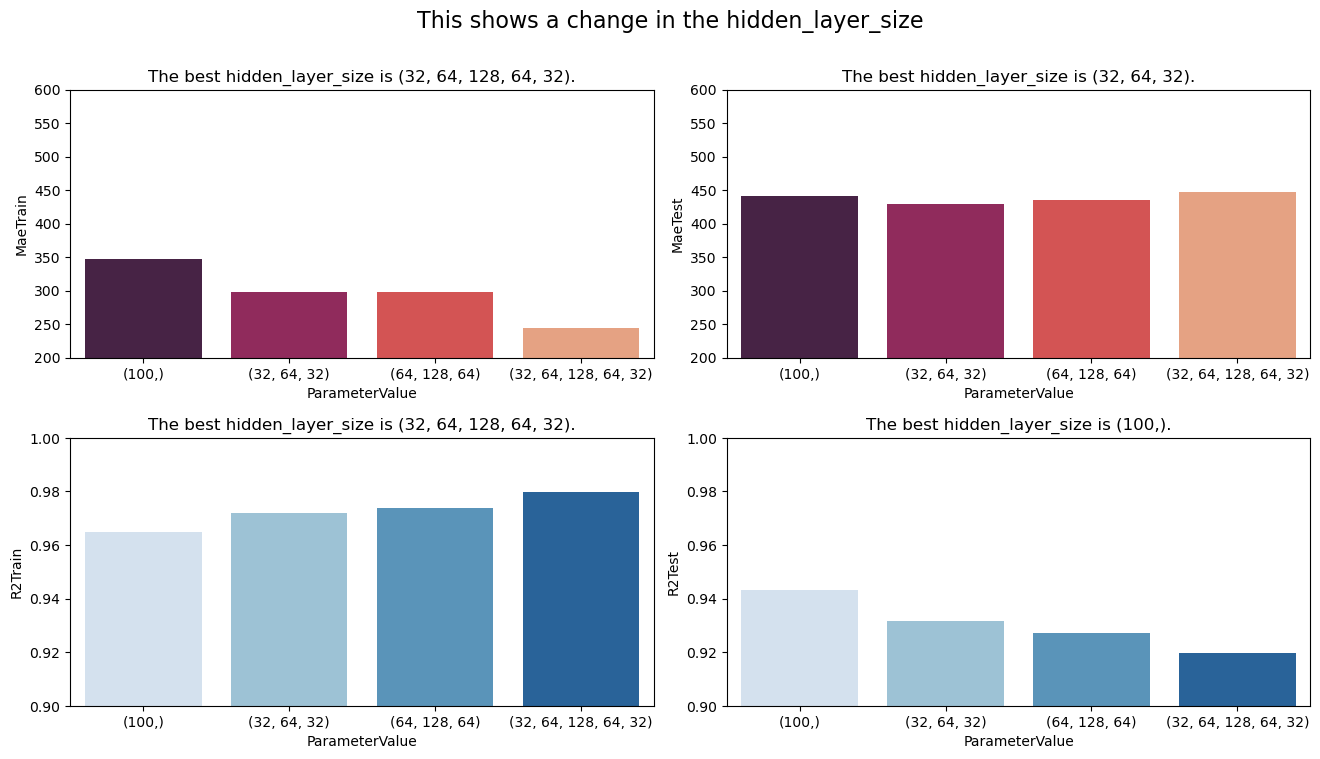

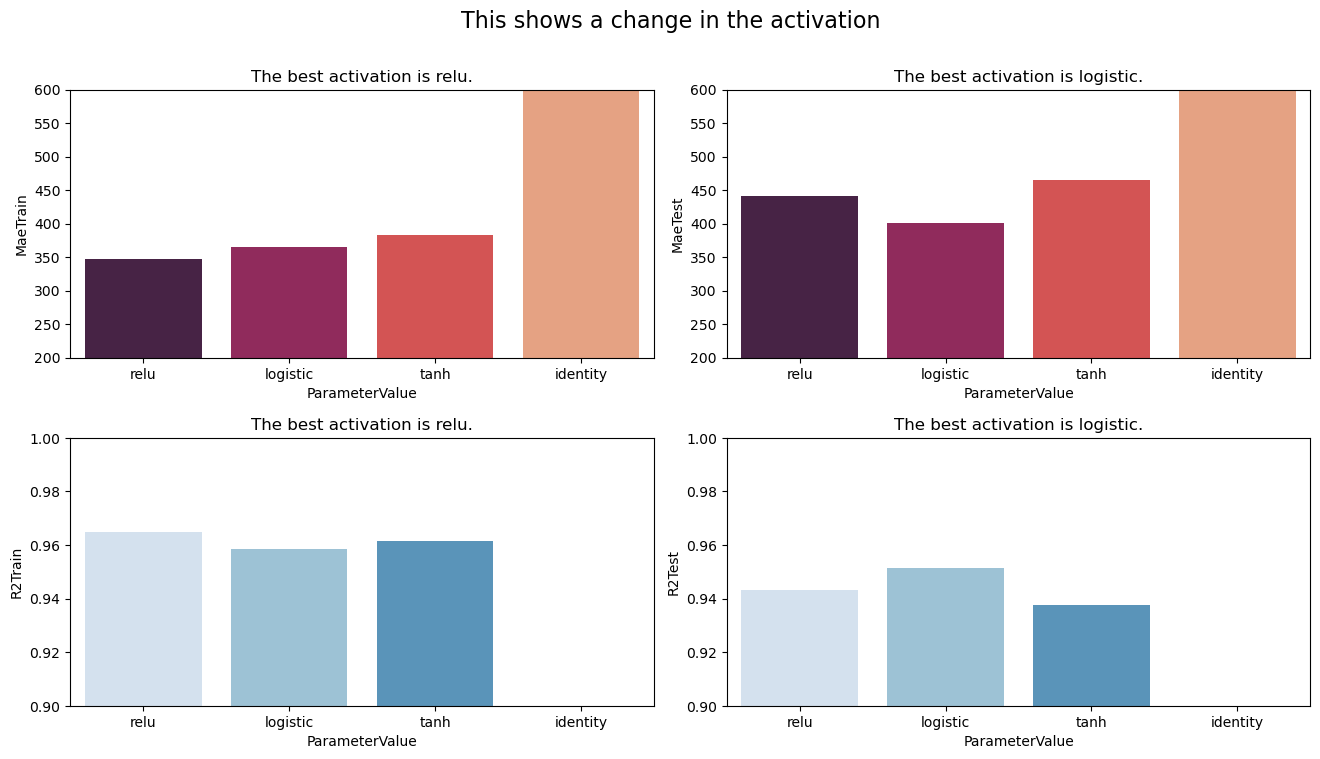

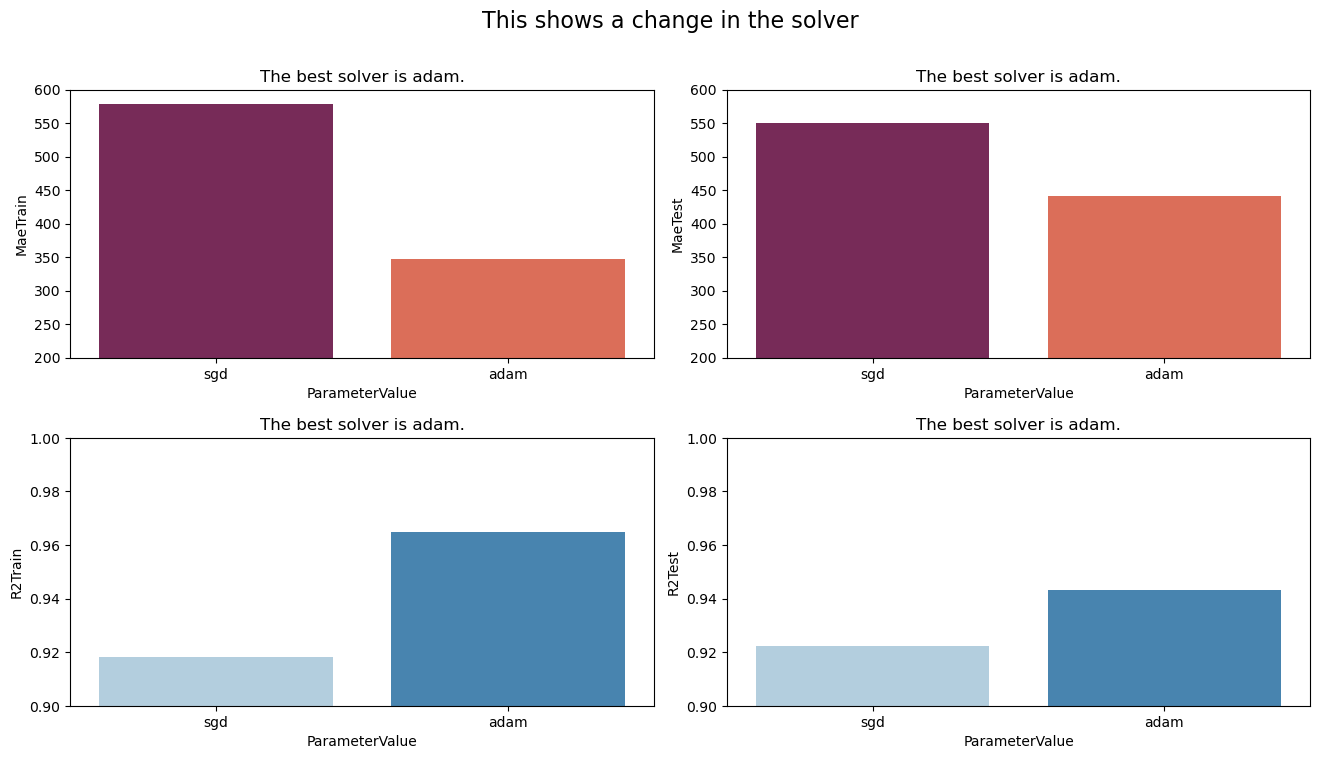

In [195]:
# defining a function for barplots for some of the parameters to compare mae and r2
def plot_bars(data_filter):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter]

    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTrain", ax=mae_train_axes, palette="rocket")
    min_mae_train_df = plot_data[["ParameterValue", "MaeTrain"]]
    min_mae_train = min_mae_train_df["MaeTrain"].min()
    min_mae_train_df = min_mae_train_df[min_mae_train_df["MaeTrain"] == min_mae_train]
    min_mae_train = min_mae_train_df["ParameterValue"].to_string(index=False)
    mae_train_axes.set_title(f"The best {data_filter} is {min_mae_train}.")
    mae_train_axes.set_ylim(200, 600)

    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTest", ax=mae_test_axes, palette="rocket")
    min_mae_test_df = plot_data[["ParameterValue", "MaeTest"]]
    min_mae_test = min_mae_test_df["MaeTest"].min()
    min_mae_test_df = min_mae_test_df[min_mae_test_df["MaeTest"] == min_mae_test]
    min_mae_test = min_mae_test_df["ParameterValue"].to_string(index=False)
    mae_test_axes.set_title(f"The best {data_filter} is {min_mae_test}.")
    mae_test_axes.set_ylim(200, 600)

    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Train", ax=r2_train_axes, palette="Blues")
    max_r2_train_df = plot_data[["ParameterValue", "R2Train"]]
    max_r2_train = max_r2_train_df["R2Train"].max()
    max_r2_train_df = max_r2_train_df[max_r2_train_df["R2Train"] == max_r2_train]
    max_r2_train = max_r2_train_df["ParameterValue"].to_string(index=False)
    r2_train_axes.set_title(f"The best {data_filter} is {max_r2_train}.")
    r2_train_axes.set_ylim(0.9, 1)

    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Test", ax=r2_test_axes, palette="Blues")
    max_r2_test_df = plot_data[["ParameterValue", "R2Test"]]
    max_r2_test = max_r2_test_df["R2Test"].max()
    max_r2_test_df = max_r2_test_df[max_r2_test_df["R2Test"] == max_r2_test]
    max_r2_test = max_r2_test_df["ParameterValue"].to_string(index=False)
    r2_test_axes.set_title(f"The best {data_filter} is {max_r2_test}.")
    r2_test_axes.set_ylim(0.9, 1)

    fig.suptitle(f"This shows a change in the {data_filter}", fontsize=16)
    fig.subplots_adjust(hspace=0.3, wspace=0.125)
    fig.savefig(f"Plots/{data_filter}.png")

# apply the function to wanted parameters for comparison
plot_bars("hidden_layer_size")
plot_bars("activation")
plot_bars("solver")

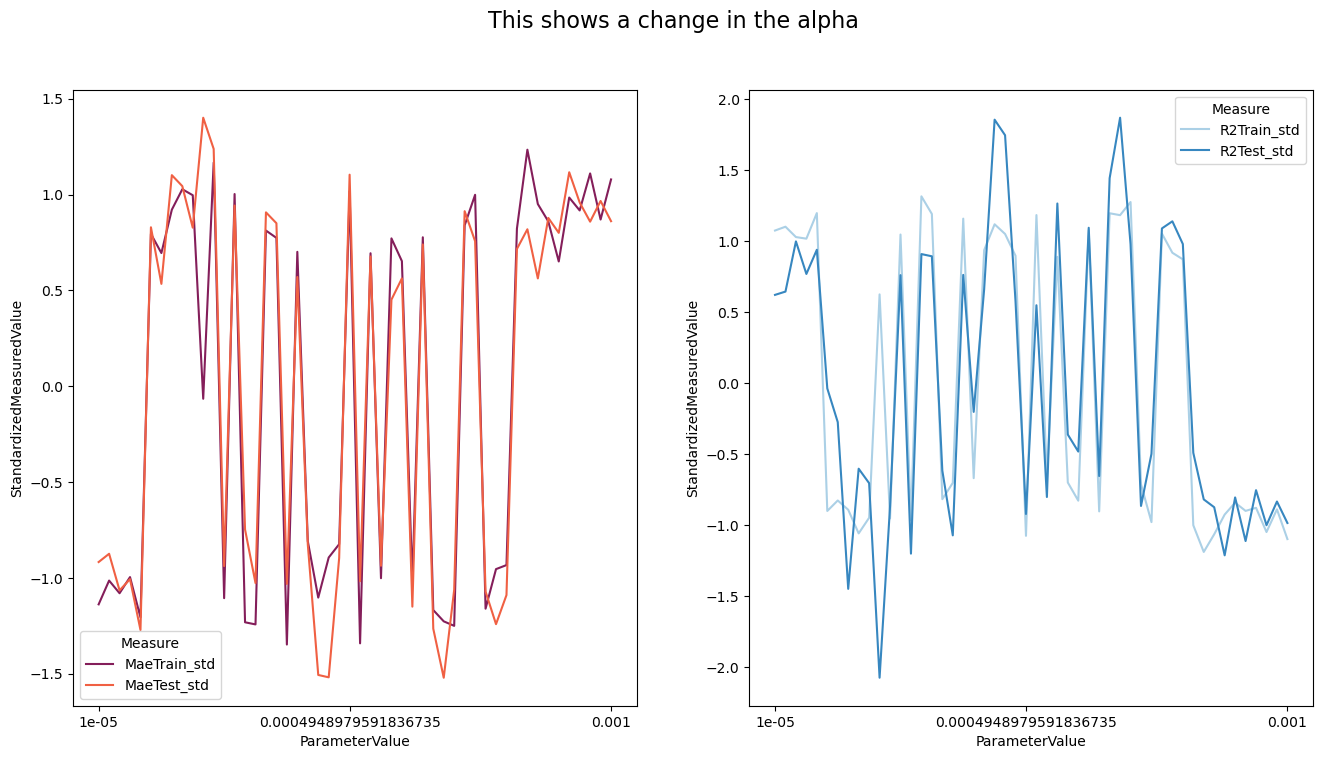

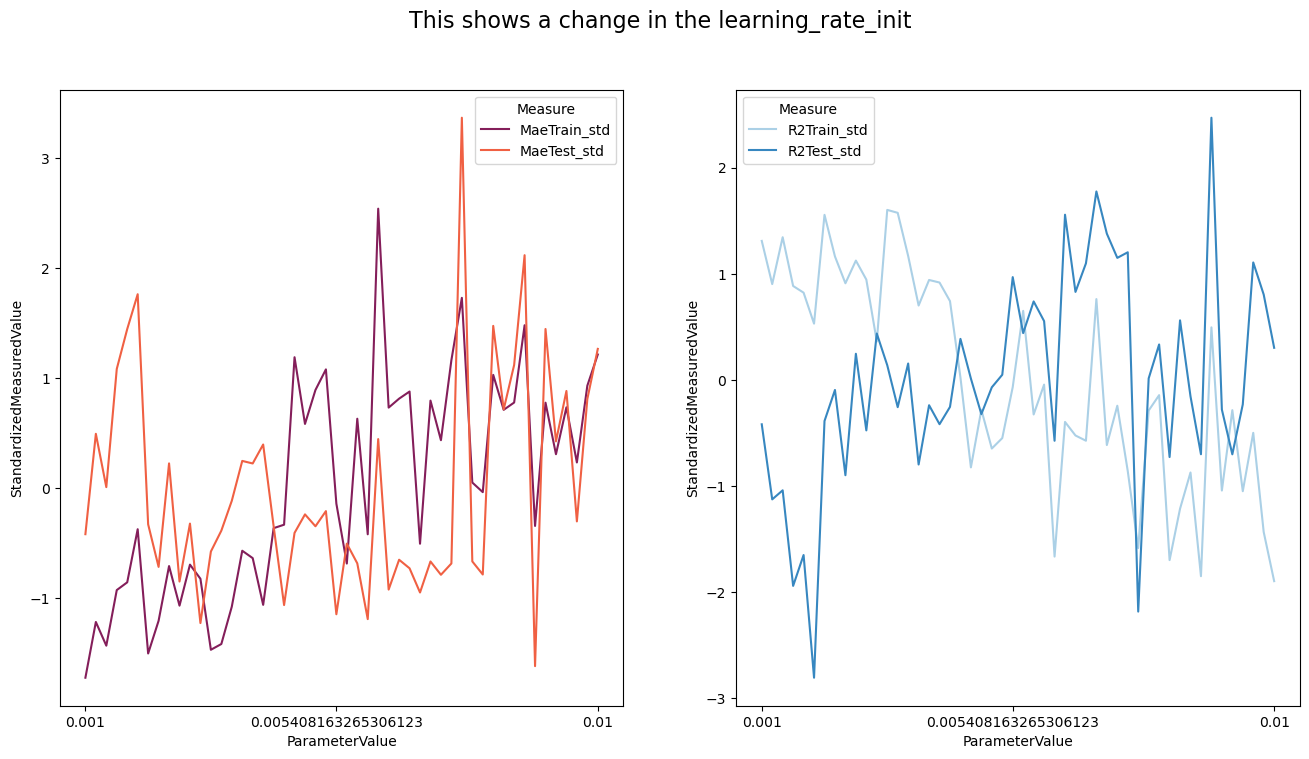

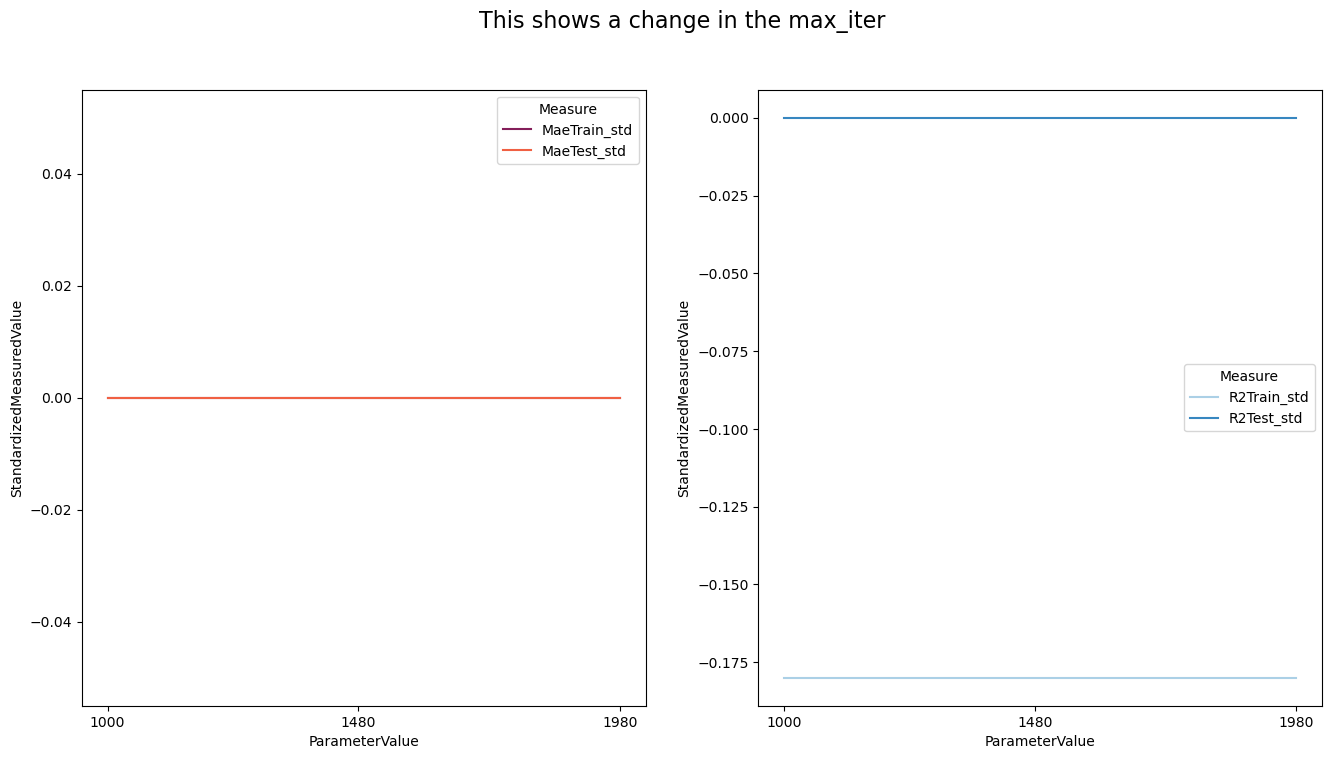

In [198]:
# defining a function for standardization to have a better look at the change of the parameters
standardize_df_col = lambda df_c: (df_c - df_c.mean()) / df_c.std()

# defining a function for lineplots for some of the parameters to compare mae and r2
def plot_lines(data_filter):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter]
    standardized = standardize_df_col(plot_data[["MaeTrain", "MaeTest", "R2Train", "R2Test"]])
    standardized_data = pd.concat([plot_data, standardized], axis=1)
    standardized_data.columns.values[6] = "MaeTrain_std"
    standardized_data.columns.values[7] = "MaeTest_std"
    standardized_data.columns.values[8] = "R2Train_std"
    standardized_data.columns.values[9] = "R2Test_std"
    plot_data_std = pd.melt(standardized_data, id_vars=["Parameter", "ParameterValue"], var_name="Measure", 
    value_vars=["MaeTrain_std", "MaeTest_std", "R2Train_std", "R2Test_std"], value_name="StandardizedMeasuredValue")

    mae_data = plot_data_std[plot_data_std["Measure"].isin(["MaeTrain_std", "MaeTest_std"])]
    mae_axes = axes[0]
    sns.lineplot(data=mae_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=mae_axes, palette="rocket")
    mae_axes.set_xticks([0, 24, 49])

    r2_data = plot_data_std[plot_data_std["Measure"].isin(["R2Train_std", "R2Test_std"])]
    r2_axes = axes[1]
    sns.lineplot(data=r2_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=r2_axes, palette="Blues")
    r2_axes.set_xticks([0, 24, 49])

    fig.suptitle(f"This shows a change in the {data_filter}", fontsize=16)
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.savefig(f"Plots/{data_filter}.png")

# apply the function to wanted parameters for comparison
plot_lines("alpha")
plot_lines("learning_rate_init")
plot_lines("max_iter")

### 3. Optimize the Hyperparameters with the Findings above

In [125]:
# subsetting the data for the optimization of the hyperparameters
ped_subset = ped.sample(frac=0.1, random_state=1)

# Define a new X of the subset with the squared feature k = 0.99, 57+46
X_subset = np.array(ped_subset[ped_subset.columns[57:103]])

# Subset of the output to predict
y_subset = ped_subset["pedestrians count"]

# Split the subset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)

In [126]:
# scale the data of the subset, so it is less sensitive to feature scaling 
# scale the inputs
scaler.fit(Xtrain_subset)
Xtrain_scaled_subset = scaler.transform(Xtrain_subset)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest_subset)
Xtest_scaled_subset = scaler.transform(Xtest_subset)
# scale the y different because we can't use standardscaler to a 1d array
mu_subset, sigma_subset = y_subset.mean(), y_subset.std()
ytest_scaled_subset = (ytest_subset - mu_subset) / sigma_subset
ytrain_scaled_subset = (ytrain_subset - mu_subset) /sigma_subset

In [129]:
# defining the model and the parameters used in RandomizedSearchCV
nnet_randomsearch = MLPRegressor(random_state=72)

parameters_randomsearch = {
    # choosing the two best hidden layer sizes and a range around them
    "hidden_layer_sizes": [(50,), (100,), (150,), (9, 18, 6), (32, 64, 32), (12, 24, 12)],
    "activation": ["logistic", "relu"], # choosing the two activation functions based on analysis above
    "solver": ["adam"], # adam was clearly the best solver in the plot above
    "alpha": np.linspace(0.00005, 0.0005, 20),
    "learning_rate_init" : np.linspace(0.0005, 0.001, 20),
    "max_iter" : range(1000, 2000, 100)
}

In [132]:
# running the RandomizedSearchCV on the subset of the data
nnet_rndm_src = RandomizedSearchCV(estimator=nnet_randomsearch, param_distributions=parameters_randomsearch, cv=2)
nnet_rndm_src.fit(Xtrain_subset, ytrain_subset)
nnet_rndm_src.best_params_

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'solver': 'adam',
 'max_iter': 1700,
 'learning_rate_init': 0.0006052631578947369,
 'hidden_layer_sizes': (9, 18, 6),
 'alpha': 0.00028684210526315793,
 'activation': 'relu'}

In [158]:
# creating a neural network with the results of the RandomSearchCV and the whole data and look at mae and r2
nnet_random = MLPRegressor(hidden_layer_sizes=(9, 18, 6), activation="relu", solver="adam", alpha=0.00047631578947368423,
    learning_rate_init=0.0006052631578947369, max_iter=1400, random_state=72)

# fit the data and run the model with new parameters
scenario_fit_evaluate("MLP Regressor", "RandomSearch", nnet_random, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  383.353667  488.387109  0.960602  0.937584
1  MLP Regressor   RandomSearch  392.851111  410.187292  0.949453  0.947754


In [143]:
# use GridSearchCV to further optimize the parameters and run now all possibilities
# defining the model and the parameters used in GridSearchCV
nnet_gridsearch = MLPRegressor(random_state=72)

parameters_gridsearch = {
    "hidden_layer_sizes": [(9, 18, 6), (32, 64, 32)], # keeping (32, 64, 32) because it looked promising before and compare it to randomized optimum
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": np.append(np.linspace(0.0003, 0.0005, 3), [0.00047631578947368423]),
    "learning_rate_init" : np.append(np.linspace(0.0005, 0.0007, 3), [0.0006052631578947369]),
    "max_iter" : range(1300, 1600, 100)
}


In [144]:
# running the GridSearchCV on the subset of the data
nnet_grid_src = GridSearchCV(estimator=nnet_gridsearch, param_grid=parameters_gridsearch, cv=2)
nnet_grid_src.fit(Xtrain_subset, ytrain_subset)
nnet_grid_src.best_params_

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'activation': 'relu',
 'alpha': 0.0003,
 'hidden_layer_sizes': (32, 64, 32),
 'learning_rate_init': 0.0005,
 'max_iter': 1300,
 'solver': 'adam'}

In [159]:
# creating a neural network with the results of GridSearchCV and the whole data and look at mae and r2
nnet_grid = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="adam", alpha=0.0003,
    learning_rate_init=0.0005, max_iter=1300, random_state=72)

# fit the data and run the model with new parameters
scenario_fit_evaluate("MLP Regressor", "GridSearch", nnet_grid, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model       Scenario   MAE_train    MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  383.353667  488.387109  0.960602  0.937584
1  MLP Regressor   RandomSearch  392.851111  410.187292  0.949453  0.947754
2  MLP Regressor     GridSearch  321.755799  442.351770  0.968152  0.934830


## Comparing the results of the 3 neural networks

In [160]:
# reading the created dataframe and have a look at it to plot it later for the analysis
comparison = pd.read_csv("comparison_mae_r2.csv", sep=";")
comparison

,Model,Scenario,MAE_train,MAE_test,R2_train,R2_test
0,MLP Regressor,Base Scenario,383.353667,488.387109,0.960602,0.937584
1,MLP Regressor,RandomSearch,392.851111,410.187292,0.949453,0.947754
2,MLP Regressor,GridSearch,321.755799,442.351770,0.968152,0.934830


(0.9, 1.0)

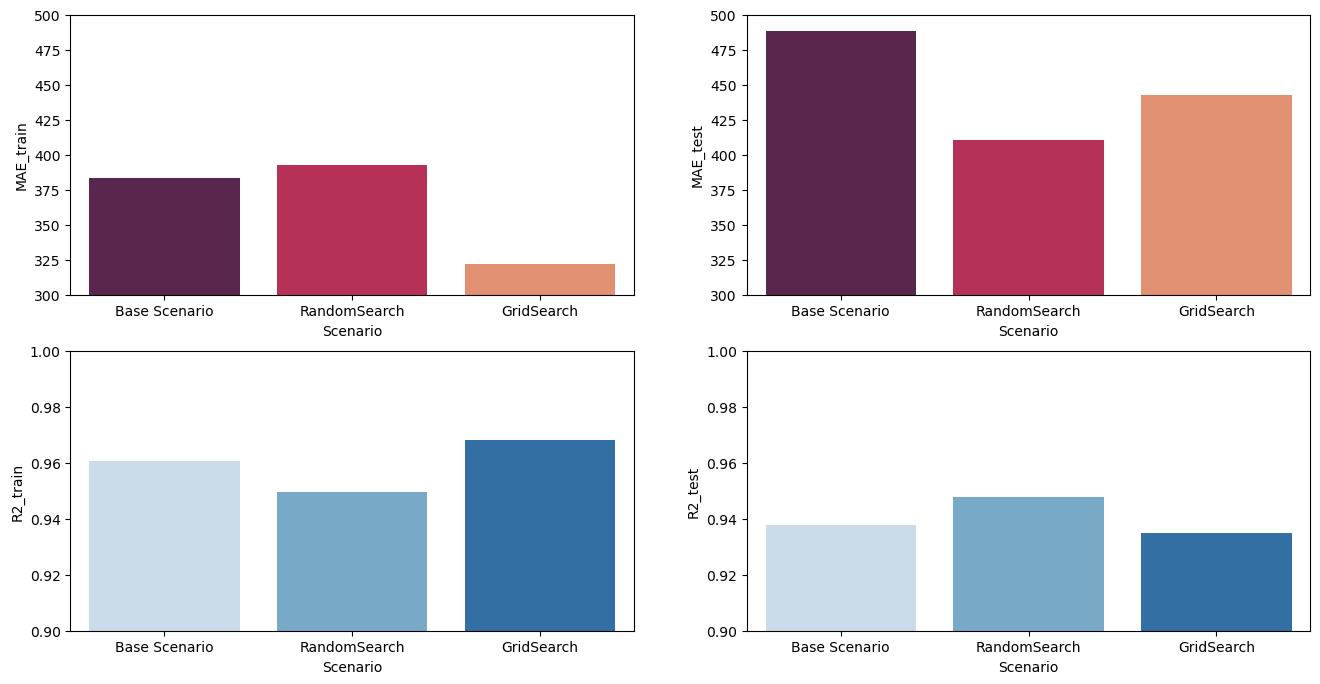

In [162]:
# plotting the comparison
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

mae_train_axes = axes[0, 0]
sns.barplot(data=comparison, x="Scenario", y="MAE_train", ax=mae_train_axes, palette="rocket")
mae_train_axes.set_ylim(300, 500)

mae_test_axes = axes[0, 1]
sns.barplot(data=comparison, x="Scenario", y="MAE_test", ax=mae_test_axes, palette="rocket")
mae_test_axes.set_ylim(300, 500)

r2_train_axes = axes[1, 0]
sns.barplot(data=comparison, x="Scenario", y="R2_train", ax=r2_train_axes, palette="Blues")
r2_train_axes.set_ylim(0.9, 1.0)

r2_test_axes = axes[1, 1]
sns.barplot(data=comparison, x="Scenario", y="R2_test", ax=r2_test_axes, palette="Blues")
r2_test_axes.set_ylim(0.9, 1.0)

# Yannik

In [ ]:
# Load the data and clean the Columns
ped = pd.read_csv("data_clean_with_dummies.csv")
ped = ped.drop(["Unnamed: 0"], axis = 1)

# Define a new X with the squared feature k = 0.99, 57+46
X = ped[ped.columns[57:103]]


# Without CPA
#X = ped[ped.columns[3:57]]


# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets


# HTIS IS NOT SCALED !!!!!!!!!!!!!!!!!!!!

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)


## Exploration

### Establish baseline

In [ ]:
def mae_score_measure_all(model):
    mae_train = mean_absolute_error(ytrain, model.predict(Xtrain))
    mae_test = mean_absolute_error(ytest, model.predict(Xtest))
    score_train = model.score(Xtrain, ytrain)
    score_test = model.score(Xtest, ytest)

    return mae_train, mae_test, score_train, score_test
    

# Initiate Random Forest with standard parameters as a basline
forest_baseline = RandomForestRegressor(random_state=144,n_jobs=-1)
forest_baseline.fit(Xtrain, ytrain)

rf_mae_train_baseline, rf_mae_test_baseline, rf_score_train_baseline, rf_score_test_basline = mae_score_measure_all(forest_baseline)

In [ ]:
# Print results
print("----- Baseline MAE and Score -----")
print()
print("-- Training data MAE --")
print(f"Random forest MAE   :   {rf_mae_train_baseline:>10.2f}")
print(f"Random forest Score :   {rf_score_train_baseline}")
print()
print("-- Validation data MAE --")
print(f"Random forest MAE   : {rf_mae_test_baseline:>10.2f}")
print(f"Random forest Score : {rf_score_test_basline}")

# Setting the baseline as the best values and change it if better appear
rf_mae_train_best = rf_mae_train_baseline
rf_score_train_best = rf_score_train_baseline
rf_mae_test_best = rf_mae_test_baseline
rf_score_test_best = rf_score_test_basline

----- Baseline MAE and Score -----

-- Training data MAE --

Random forest MAE   :       148.60

Random forest Score :   0.9886067935879173

-- Validation data MAE --
Random forest MAE   :     340.00

Random forest Score : 0.9428547425750197

### Exploratory Parameter analasys

Estimator

In [ ]:
#n_estimators: how many trees should we consider , Defalut = 100
n_estimators = [x for x in range(50, 800, 50)]
#ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning,  Defalut = 0
ccp_alpha = [x for x in np.linspace(0, 0.3, 30)]
#The max_depth of a tree in Random Forest is defined as the longest path between the root node and the leaf node  Defalut = None, only measurabel, when using high numbers
max_depth = [x for x in range(10, 30, 2)]
max_depth2 = [x for x in range(30, 201, 10)]
max_depth.extend(max_depth2)
##################################################max_depth.append(99999)

# This resembles the number of maximum features provided to each tree in a random forest,  Defalut = 1
max_features = [x for x in range(1, 41, 2)]

max_features_decimal = [x for x in np.linspace(0.01, 1, 20)]

##################################################max_features.extend(["sqrt", "log2", None])

# min_sample_split: the minimum required number of observations in node in order to split it  Defalut = 2
min_samples_split = [x for x in range(2, 30, 1)]
# min_samples_leaf: minimum number of samples that should be present in the leaf node after splitting a node  Defalut = 1
min_samples_leaf = [x for x in range(1, 15, 1)]

#Create a dict with all parameters
all_parameters_dict = {"n_estimators":n_estimators, "ccp_alpha":ccp_alpha, "max_depth":max_depth, "max_features":max_features,"max_features_decimal":max_features_decimal,
                        "min_samples_split":min_samples_split, "min_samples_leaf":min_samples_leaf}

Testing parameters on Default tree

In [ ]:
# creating a dataframe to save the results
results_rf = pd.DataFrame(columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter(param, param_values, initialize_model):
    global results_rf
    for param_value in param_values:
        rf_param = initialize_model(param_value)
        # Fit the network to the train data
        rf_param.fit(Xtrain, ytrain)
        # Make predictions
        ypred_train = rf_param.predict(Xtrain)
        ypred_test = rf_param.predict(Xtest)
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_train)
        mae_param_test = mean_absolute_error(ytest, ypred_test)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_train)
        r2_param_test = r2_score(ytest, ypred_test)

        # adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results_rf = pd.concat([results_rf, row])


# apply the function to the different parameters
test_parameter("n_estimators", n_estimators, lambda value: RandomForestRegressor(n_estimators=value, random_state=144,n_jobs=-1))
test_parameter("ccp_alpha", ccp_alpha, lambda value: RandomForestRegressor(ccp_alpha=value, random_state=144,n_jobs=-1))
test_parameter("max_depth", max_depth, lambda value: RandomForestRegressor(max_depth=value, random_state=144,n_jobs=-1))
test_parameter("max_features", max_features, lambda value: RandomForestRegressor(max_features=value, random_state=144,n_jobs=-1))
test_parameter("max_features_decimal", max_features_decimal, lambda value: RandomForestRegressor(max_features=value, random_state=144,n_jobs=-1))
test_parameter("min_samples_split", min_samples_split, lambda value: RandomForestRegressor(min_samples_split=value, random_state=144,n_jobs=-1))
test_parameter("min_samples_leaf", min_samples_leaf, lambda value: RandomForestRegressor(min_samples_leaf=value, random_state=144,n_jobs=-1))

# merging results into dataframe and safe it as csv to work with it later on
results_rf = results_rf.reset_index().drop(columns="index")
results_rf.to_csv("param_testing_randfor.csv", sep=";", index=False)



In [ ]:
# reading the created dataframe and have a look at it to plot it later for the analysis
param_testing = pd.read_csv("param_testing_randfor.csv", sep=";")
param_testing

Visualize results

In [ ]:
# defining a function for barplots for some of the parameters to compare mae and r2
standardize_df_col = lambda df_c: (df_c - df_c.mean()) / df_c.std()

def plot_lines(data_filter):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plot_data = param_testing.loc[param_testing["Parameter"] == data_filter]

    axs[0].plot(plot_data["ParameterValue"], standardize_df_col(plot_data["MaeTrain"]), color="b", label="Train")
    axs[0].plot(plot_data["ParameterValue"], standardize_df_col(plot_data["MaeTest"]), color="c", label="Test")


    axs[1].plot(plot_data["ParameterValue"], plot_data["R2Train"], color="r", label="Train")
    axs[1].plot(plot_data["ParameterValue"], plot_data["R2Test"], color="y", label="Test")


    # Add the x- and y-axes labels
    axs[0].set_xlabel(f"{data_filter}")
    axs[0].set_ylabel("Standarized Score")
    axs[1].set_xlabel(f"{data_filter}")
    axs[1].set_ylabel("Standarized MAE")


    fig.suptitle(f"This shows a change in the {data_filter}", fontsize=16)



# apply the function to wanted parameters for comparison
plot_lines("n_estimators")
plot_lines("ccp_alpha")
plot_lines("max_depth")
plot_lines("max_features")
plot_lines("max_features_decimal")
plot_lines("min_samples_split")
plot_lines("min_samples_leaf")


In [ ]:
# create figure frome saved pictures
fig = plt.figure(figsize=(40, 40))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
img1 = Image.open("pictures/score_and_mae.png")
img2 = Image.open("pictures/score_and_mae2.png")
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("Second")

In [ ]:
img3 = Image.open("pictures/score_and_mae3.png")
img3.show()

### Optimisation for the whole Dataset

In [ ]:
# Setting up the first Hyperparameters that should be tuned, due to the size of the Dataset only very few
# Number of trees in random forest
n_estimators = [int(x) for x in range(100, 501, 50)]
# Number of features to consider at every split
max_features = [0.25, 0.5, 1.0, None]
# Method to controll complexity 
ccp_alpha = [0, 0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = {"n_estimators": n_estimators,
               "max_features": max_features,
               "ccp_alpha": ccp_alpha}

param_standard = {"n_estimators": 100,
               "max_features": 1.0,
               "ccp_alpha": 0}



In [ ]:
# Although they are influencing each other, this is too much for my Comuter, a proper optimization is shown below with a 
# subset and Cross validation takes too much computing power, due to the lage data:

# Setting up Lists for the MAE for all parameters
mae_test_ne = []
mae_test_mf = []
mae_test_ccp = []
# Setting a count for progress
i = 1


def optimize_parameter(parameter, param_values, param_values_fix1, param_valuesfix_2, initialize_model):
    for param_value in param_values:
        mae_test = []

        rf_param = initialize_model(param_value, param_values_fix1, param_valuesfix_2)
        # Fit the network to the train data
        rf_param.fit(Xtrain, ytrain)
        # Make predictions
        ypred_test = rf_param.predict(Xtest_scaled)

        # Compute the MAE
        mae_param_test = mean_absolute_error(ytest, ypred_test)


        # adding them in a list
        mae_test.append(mae_param_test)

    # getting the minimum values
    index_best = np.argmin(mae_test)
    best_parameter = param_values[index_best]

    return best_parameter


best_n_estimator = optimize_parameter("n_estimators", n_estimators, 1.0 , 0, 
                    lambda value, value_fix1, value_fix2: RandomForestRegressor(n_estimators=value, max_features=value_fix1, ccp_alpha=value_fix2, random_state=144,n_jobs=-1))

best_max_feat = optimize_parameter("max_features", max_features, best_n_estimator, 0, 
                    lambda value, value_fix1, value_fix2: RandomForestRegressor(n_estimators=value_fix1, max_features=value, ccp_alpha=value_fix2, random_state=144,n_jobs=-1))

best_ccp = optimize_parameter("ccp_alpha", ccp_alpha, best_n_estimator, best_max_feat, 
                    lambda value, value_fix1, value_fix2: RandomForestRegressor(n_estimators=value_fix1, max_features=value_fix2, ccp_alpha=value, random_state=144,n_jobs=-1))


# Creating the best Random forest with those found parameters
forest_optim_all = RandomForestRegressor(n_estimators=best_n_estimator, max_features=best_max_feat, ccp_alpha=best_ccp, random_state=144,n_jobs=-1)
forest_optim_all.fit(Xtrain, ytrain)


# Calculating the MAE for this forest
mae_test_best = mean_absolute_error(ytest, forest_optim_all.predict(Xtest))

print(f"The best MAE Test is {mae_test_best:>10.2f} with, n_estimators: {best_n_estimator}, max_features: {best_max_feat}, ccp_alpha: {best_ccp}")


The best MAE Test is     338.19 with, n_estimators: 350, max_features: 1.0, ccp_alpha: 0.3

In [ ]:
# Calculating the values for the found Forest
rf_mae_train_all, rf_mae_test_all, rf_score_train_all, rf_score_test_all = mae_score_measure_all(forest_optim_all)


In [ ]:
# Measure the MAE and the Score for the test and the trining data
forest_optim_all_backup = RandomForestRegressor(random_state=144, n_jobs=-1,  n_estimators = 350, max_features = 1.0, ccp_alpha = 0.3)
forest_optim_all_backup.fit(Xtrain, ytrain)
rf_mae_train_all, rf_mae_test_all, rf_score_train_all, rf_score_test_all = mae_score_measure_all(forest_optim_all_backup)


In [ ]:
#Checking if the best score needs to be updated
if rf_mae_train_all < rf_mae_train_best and rf_score_train_all > rf_score_train_best:
    rf_mae_train_best = rf_mae_train_all
    rf_score_train_best = rf_score_train_all
if rf_mae_test_all < rf_mae_test_best and rf_score_test_all > rf_score_test_best:
    rf_mae_test_best = rf_mae_test_all
    rf_score_test_best = rf_score_test_all

# Print results
print("             --- Hyper1 MAE and Score --- This is the basline --- This is the best ---")
print()
print("-- Training data MAE --")
print(f"Random forest MAE   :   {rf_mae_train_all:>10.2f}     |   {rf_mae_train_baseline:>10.2f}      |   {rf_mae_train_best:>10.2f}  ")
print(f"Random forest Score :   {rf_score_train_all:>10.2f}     |   {rf_score_train_baseline:>10.2f}      |   {rf_score_train_best:>10.2f}  ")
print()
print("-- Validation data MAE --")
print(f"Random forest MAE   :   {rf_mae_test_all:>10.2f}      |   {rf_mae_test_baseline:>10.2f}     |   {rf_mae_test_best:>10.2f}  ")
print(f"Random forest Score :   {rf_score_test_all:>10.2f}      |   {rf_score_test_basline:>10.2f}     |   {rf_score_test_best:>10.2f}  ")

             --- Hyper1 MAE and Score --- This is the basline --- This is the best ---

-- Training data MAE --

Random forest MAE   :       150.18     |       148.55      |       148.55  

Random forest Score :         0.99     |         0.99      |         0.99  

-- Validation data MAE --

Random forest MAE   :       350.37      |       343.34     |       343.34
  
Random forest Score :         0.95      |         0.94     |         0.95 

## RandomizedSearchCV With Subset

In [ ]:
# Load the data and clean the Columns
ped = pd.read_csv("data_clean_with_dummies.csv")
ped = ped.drop(["Unnamed: 0"], axis = 1)



ped_subset = ped.sample(frac=0.1, random_state=1)

# Define a new X with the squared feature k = 0.99, 57+46
X_subset = np.array(ped_subset[ped_subset.columns[57:103]])

X_subset = ped_subset[ped_subset.columns[57:103]]


# Output to predict
y_subset = ped_subset["pedestrians count"]

# Split the dataset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)
## Hyperparametertuning
### Establish baseline
# Initiate Random Forest with standard parameters as a basline
forest_baseline_sub = RandomForestRegressor(random_state=144,n_jobs=-1)
forest_baseline_sub.fit(Xtrain_subset, ytrain_subset)



def mae_score_measure_sub(model):
    mae_train = mean_absolute_error(ytrain_subset, model.predict(Xtrain_subset))
    mae_test = mean_absolute_error(ytest_subset, model.predict(Xtest_subset))
    score_train = model.score(Xtrain_subset, ytrain_subset)
    score_test = model.score(Xtest_subset, ytest_subset)
    return mae_train, mae_test, score_train, score_test 


# Measure the MAE and the Score for the test and the trining data
rf_mae_train_baseline_subset, rf_mae_test_baseline_subset, rf_score_train_baseline_subset, rf_score_test_basline_subset = mae_score_measure_sub(forest_baseline_sub)


# Print results
print("----- Baseline MAE and Score -----")
print()
print("-- Training data MAE --")
print(f"Random forest MAE   :   {rf_mae_train_baseline_subset:>10.2f}")
print(f"Random forest Score :   {rf_score_train_baseline_subset:>10.2f}")
print()
print("-- Validation data MAE --")
print(f"Random forest MAE   : {rf_mae_test_baseline_subset:>10.2f}")
print(f"Random forest Score : {rf_score_test_basline_subset:>10.2f}")

# Setting the baseline as the best values and change it if better appear
rf_mae_train_best_subset = rf_mae_train_baseline_subset
rf_score_train_best_subset = rf_score_train_baseline_subset
rf_mae_test_best_subset = rf_mae_test_baseline_subset
rf_score_test_best_subset = rf_score_test_basline_subset

----- Baseline MAE and Score -----

-- Training data MAE --

Random forest MAE   :       196.44

Random forest Score :         0.98

-- Validation data MAE --

Random forest MAE   :     571.20

Random forest Score :       0.90

In [ ]:
# Number of trees in random forest
n_estimators = [x for x in range(300, 601, 50)]
# Method to controll complexity 
ccp_alpha = [x for x in np.linspace(0.0, 0.2, 10)]
#max_depth of a tree
max_depth = [int(x) for x in range(5, 30, 5)]
max_depth.append(None)
# Number of features to consider at every split
max_features = [x for x in np.linspace(0.0, 1, 5)]
max_features.extend([None])
# min_sample_split: the minimum required number of observations in node in order to split it  Defalut = 2
min_samples_split = [int(x) for x in range(5, 20, 5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [x for x in range(1, 8, 2)]
# Method of selecting samples for training each tree
bootstrap = [True, False]



# Create the param grid
param_distributions = {"n_estimators": n_estimators,
               "ccp_alpha": ccp_alpha,
               "max_depth": max_depth,
               "max_features": max_features,
               "min_samples_leaf": min_samples_leaf,
               "min_samples_split":min_samples_split,
               "bootstrap": bootstrap
            }


# In total 1.248.000 possibileties
length = [len(values) for key, values in param_distributions.items()]
print(f"In total we have {np.prod(length)} possibleties")

forest = RandomForestRegressor(random_state=144)



In [ ]:
# Run grid search cross validation
random_search_forest_subset = RandomizedSearchCV(estimator = forest, param_distributions = param_distributions, verbose=2,n_iter = 5000, n_jobs = -1, cv = 4)
random_search_forest_subset.fit(Xtrain_subset, ytrain_subset)
# Finding out best parameteers
random_search_forest_subset.best_params_

{'n_estimators': 500,

 'min_samples_split': 15,

 'min_samples_leaf': 5,

 'max_features': 0.75,

 'max_depth': 25,

 'ccp_alpha': 0.2,

 'bootstrap': False}

In [ ]:
# Measure the MAE and the Score for the test and the trining data
rf_mae_train_hype_rand_subset, rf_mae_test_hype_rand_subset, rf_score_train_hype_rand_subset, rf_score_test_hype_rand_subset = mae_score_measure_sub(random_search_forest_subset)

In [ ]:
#When the Optimization is not saved this is the calculated forest:
forest_hype_rand_subset=RandomForestRegressor(random_state=144, n_jobs = -2, n_estimators= 500, min_samples_split= 15, min_samples_leaf = 5, max_features = 0.75, max_depth= 25, ccp_alpha =0.2, bootstrap= False)
forest_hype_rand_subset.fit(Xtrain_subset, ytrain_subset)

rf_mae_train_hype_rand_subset = mean_absolute_error(ytrain_subset, forest_hype_rand_subset.predict(Xtrain_subset))
rf_mae_test_hype_rand_subset = mean_absolute_error(ytest_subset, forest_hype_rand_subset.predict(Xtest_subset))
rf_score_train_hype_rand_subset = forest_hype_rand_subset.score(Xtrain_subset, ytrain_subset)
rf_score_test_hype_rand_subset = forest_hype_rand_subset.score(Xtest_subset, ytest_subset)

In [ ]:
#Checking if the best score needs to be updated
if rf_mae_train_hype_rand_subset < rf_mae_train_best_subset and rf_score_train_hype_rand_subset > rf_score_train_best_subset:
    rf_mae_train_best_subset = rf_mae_train_hype_rand_subset
    rf_score_train_best_subset = rf_score_train_hype_rand_subset
if rf_mae_test_hype_rand_subset < rf_mae_test_best_subset and rf_score_test_hype_rand_subset > rf_score_test_best_subset:
    rf_mae_test_best_subset = rf_mae_test_hype_rand_subset
    rf_score_test_best_subset = rf_score_test_hype_rand_subset

# Print results
print("             --- Hyper Subset MAE and Score --- This is the basline Subset --- This is the best Subset ---")
print()
print("-- Training data MAE --")
print(f"Random forest MAE   :   {rf_mae_train_hype_rand_subset:>10.2f}     |   {rf_mae_train_baseline_subset:>10.2f}      |   {rf_mae_train_best_subset:>10.2f}  ")
print(f"Random forest Score :   {rf_score_train_hype_rand_subset:>10.2f}     |   {rf_score_train_baseline_subset:>10.2f}      |   {rf_score_train_best_subset:>10.2f}  ")
print()
print("-- Validation data MAE --")
print(f"Random forest MAE   :   {rf_mae_test_hype_rand_subset:>10.2f}      |   {rf_mae_test_baseline_subset:>10.2f}     |   {rf_mae_test_best_subset:>10.2f}  ")
print(f"Random forest Score :   {rf_score_test_hype_rand_subset:>10.2f}      |   {rf_score_test_basline_subset:>10.2f}     |   {rf_score_test_best_subset:>10.2f}  ")

             --- Hyper1 MAE and Score --- This is the basline --- This is the best ---

-- Training data MAE --

Random forest MAE   :      2656.37     |       148.55      |       148.55  

Random forest Score :        -0.00     |         0.99      |         0.99  

-- Validation data MAE --

Random forest MAE   :      2664.45      |       343.34     |       343.34  

Random forest Score :        -0.00      |         0.94     |         0.94  

### More Specific with GridSearchCV

In [ ]:
# Number of trees in random forest, Randomized was 500
######################################################n_estimators = [500, 450, 100]
n_estimators = [550,500]
# Method to controll complexity, Randomized was 0.2
######################################################ccp_alpha = [0.3, 0.2, 0.1, 0]
ccp_alpha = [0.3, 0.2]
#max_depth of a tree, Randomized was 25
max_depth = [25, None]
# Number of features to consider at every split, Randomized was 0.75
max_features = [0.75, None]
# min_sample_split: the minimum required number of observations in node in order to split it, Randomized was 15
min_samples_split = [20, 2]
# Minimum number of samples required at each leaf node, Randomized was 5
min_samples_leaf = [5, 1]
# Method of selecting samples for training each tree, Randomized was False
bootstrap = [False, True]



# Create the param grid
param_distributions = {"n_estimators": n_estimators,
               "ccp_alpha": ccp_alpha,
               "max_depth": max_depth,
               "max_features": max_features,
               "min_samples_leaf": min_samples_leaf,
               "min_samples_split":min_samples_split,
               "bootstrap": bootstrap
            }


# In total possibileties
length = [len(values) for key, values in param_distributions.items()]
print(f"In total we have {np.prod(length)} possibleties")
forest = RandomForestRegressor(random_state=144)



In [ ]:
# Run grid search cross validation
grid_search_forest_subset = GridSearchCV(estimator = forest, param_grid = param_distributions, verbose=2, n_jobs = -1, cv = 5)
grid_search_forest_subset.fit(Xtrain_subset, ytrain_subset)
# Finding out best parameteers
grid_search_forest_subset.best_params_

{'bootstrap': True,
 
 'ccp_alpha': 0.2,
 
 'max_depth': None,
 
 'max_features': None,
 
 'min_samples_leaf': 1,
 
 'min_samples_split': 2,
 
 'n_estimators': 550}

In [ ]:
# Measure the MAE and the Score for the test and the trining data
rf_mae_train_hype_search_subset, rf_mae_test_hype_search_subset, rf_score_train_hype_search_subset, rf_score_test_hype_search_subset = mae_score_measure_sub(grid_search_forest_subset)


In [ ]:
#When the Optimization is not saved this is the calculated forest:
forest_hype_grid_subset=RandomForestRegressor(random_state=144, n_jobs = -1, n_estimators= 550, min_samples_split= 2, min_samples_leaf = 1, max_features = None, max_depth= None, ccp_alpha =0.2, bootstrap= True)
forest_hype_grid_subset.fit(Xtrain_subset, ytrain_subset)


rf_mae_train_hype_search_subset = mean_absolute_error(ytrain_subset, forest_hype_grid_subset.predict(Xtrain_subset))
rf_mae_test_hype_search_subset = mean_absolute_error(ytest_subset, forest_hype_grid_subset.predict(Xtest_subset))
rf_score_train_hype_search_subset = forest_hype_grid_subset.score(Xtrain_subset, ytrain_subset)
rf_score_test_hype_search_subset = forest_hype_grid_subset.score(Xtest_subset, ytest_subset)

In [ ]:
#Checking if the best score needs to be updated
if rf_mae_train_hype_search_subset < rf_mae_train_best_subset and rf_score_train_hype_search_subset > rf_score_train_best_subset:
    rf_mae_train_best_subset = rf_mae_train_hype_search_subset
    rf_score_train_best_subset = rf_score_train_hype_search_subset
if rf_mae_test_hype_search_subset < rf_mae_test_best_subset and rf_score_test_hype_search_subset > rf_score_test_best_subset:
    rf_mae_test_best_subset = rf_mae_test_hype_search_subset
    rf_score_test_best_subset = rf_score_test_hype_search_subset

# Print results
print("             --- Hyper Subset MAE and Score --- This is the basline Subset --- This is the best Subset ---")
print()
print("-- Training data MAE --")
print(f"Random forest MAE   :   {rf_mae_train_hype_search_subset:>10.2f}     |   {rf_mae_train_baseline_subset:>10.2f}      |   {rf_mae_train_best_subset:>10.2f}  ")
print(f"Random forest Score :   {rf_score_train_hype_search_subset:>10.2f}     |   {rf_score_train_baseline_subset:>10.2f}      |   {rf_score_train_best_subset:>10.2f}  ")
print()
print("-- Validation data MAE --")
print(f"Random forest MAE   :   {rf_mae_test_hype_search_subset:>10.2f}      |   {rf_mae_test_baseline_subset:>10.2f}     |   {rf_mae_test_best_subset:>10.2f}  ")
print(f"Random forest Score :   {rf_score_test_hype_search_subset:>10.2f}      |   {rf_score_test_basline_subset:>10.2f}     |   {rf_score_test_best_subset:>10.2f}  ")

             --- Hyper Subset MAE and Score --- This is the basline Subset --- This is the best Subset ---

-- Training data MAE --

Random forest MAE   :       192.29     |       196.44      |       195.36  

Random forest Score :         0.98     |         0.98      |         0.98  

-- Validation data MAE --

Random forest MAE   :       563.03      |       571.20     |       563.03  

Random forest Score :         0.90      |         0.90     |         0.90

## Visualization

In [ ]:
ped = pd.read_csv("data_clean_with_dummies.csv")
ped = ped.drop(["Unnamed: 0"], axis = 1)

# Define a new X with the squared feature k = 0.99, 57+46
X = ped[ped.columns[57:103]]

y = ped["pedestrians count"]


In [ ]:
# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)




In [ ]:
# Initiate Random Forest with standard parameters as a basline
best_forest = RandomForestRegressor(random_state=144, n_jobs=-1,  n_estimators = 350, max_features = 1.0, ccp_alpha = 0.3)
best_forest.fit(Xtrain, ytrain)

In [ ]:
print(
mean_absolute_error(ytrain, best_forest.predict(Xtrain)),
mean_absolute_error(ytest, best_forest.predict(Xtest)))

### This is with all data

In [ ]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts = []
for uper in split:
    part = ped.loc[(ped["pedestrians count"] >= lower) & (ped["pedestrians count"] < uper)]
    lower = uper
    seperate_parts.append(part)



### This is with Test Data

In [ ]:
Xtest_new = Xtest.reset_index(drop=True)
ytest_new = ytest.reset_index(drop=True)

In [ ]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts_y = []
seperate_parts_x = []



for uper in split:
    y_part = ytest_new[(ytest_new >= lower) & (ytest_new < uper)]
    index_for_x = y_part.index[0:len(y_part)]
    x_part = Xtest_new.loc[index_for_x,]
    lower = uper
    seperate_parts_y.append(y_part)
    seperate_parts_x.append(x_part)



### Graph

In [ ]:
# Set up the canvas
fig, axs = plt.subplots(len(seperate_parts),2,figsize=(18, 180))
# Make a scatterplot with temperature on the x-axis and number of rentals on the y axis

#################################################
#THIS IS FOR TEST ONLY
#################################################
for i in range(len(seperate_parts_y)):
    X_calc = seperate_parts_x[i]#[seperate_parts_x[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts_y[i]#["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = best_forest.predict(X_calc)

    axs[i][0].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][0].scatter(x_graph, y_pred_graph, label="Random Forest", color="green", lw=1)
    axs[i][0].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][0].legend()
    axs[i][0].set_xlabel("Time")
    axs[i][0].set_ylabel("People")
    axs[i][0].set_title("This are the Test Data")

#################################################
# THIS IS FOR ALL
#################################################
for i in range(len(seperate_parts)):
    X_calc = seperate_parts[i][seperate_parts[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts[i]["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = best_forest.predict(X_calc)

    axs[i][1].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][1].scatter(x_graph, y_pred_graph, label="Random Forest", color="green", lw=1)
    axs[i][1].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][1].legend()
    axs[i][1].set_xlabel("Time")
    axs[i][1].set_ylabel("People")
    axs[i][1].set_title("This are All Data")


In [ ]:
# create figure frome saved pictures
fig = plt.figure(figsize=(20, 200))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
img1 = Image.open("pictures/per_people_test_only.png")
img2 = Image.open("pictures/per_people.png")
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("Test")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("All")

# Keno

# Wanja

# API